# DATASET ANALYSIS

## IMPORTS


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import json


from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score
from sklearn.compose import TransformedTargetRegressor


from fairlearn.datasets import fetch_adult
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlearn.reductions import DemographicParity

import shap

## LOAD DATASET


In [3]:
# Let's load the dataset
data = pd.read_csv('./../data/synth_data_for_training.csv')

data_positive_targets = data.loc[data['checked'] == 1]
# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
data.loc[data['belemmering_niet_computervaardig'] == 1.0]['checked'].sum()

7

## DISTRIBUTION OF TARGET VALUE

<Axes: xlabel='checked', ylabel='count'>

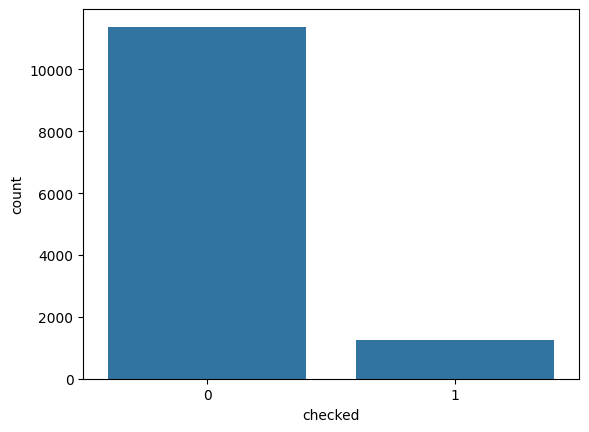

In [4]:
# Visualize the distribution of the target variable 'checked'
sns.countplot(x='checked', data=data)

In [5]:


# Create a dropdown menu with all the features
feature_dropdown = widgets.Dropdown(
    options=data.columns,
    description='Feature:',
)

# Create a new output area for the dropdown menu
output = widgets.Output()

# Define a function to update the plot when a new feature is selected
def update_plot(feature):
    with output:
        clear_output(wait=True)  # Clear the current output
        sns.histplot(data=data, x=feature, legend=True, bins="auto")
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature}')
        plt.show()

# Display the dropdown menu and the initial plot
display(feature_dropdown)
display(output)

# Call the update_plot function when a new feature is is selected
feature_dropdown.observe(lambda change: update_plot(change.new), names='value')

Dropdown(description='Feature:', options=('adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adre…

Output()

## INITIALIZE SELECTORS


In [6]:
# Select data based on variance (not the final version yet, for now just for testing)
# selector = VarianceThreshold(threshold=0.1)

In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

transform_model = TransformedTargetRegressor()

## ANALYSE BIAS IN MODEL PREDICTIONS


In [ ]:
# Define a gradient boosting classifier
classifier = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

model = TransformedTargetRegressor(regressor=classifier, inverse_func=lambda x: x>.0001)

In [ ]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
pipeline = Pipeline(steps=[ ("preprocessor", preprocessor), ('classification', classifier)])



In [ ]:
# from sklearn.ensemble import RandomForestClassifier


# # When use pipeline class
# pipeline = Pipeline([( "scaler" , StandardScaler()),
#                        ("rf",RandomForestClassifier()),
#                        ('onehot', onehotencoder)])
# # import Grid Search class
# from sklearn.model_selection import GridSearchCV
# # make lists of different parameters to check
# parameters = {
#   'n_estimators':[1,10,100,1000],
#   'min_samples_split': [2,3,4,5]
#   }
# # initialize
# grid_pipeline = GridSearchCV(pipeline,parameters)
# grid_pipeline.best_params_


In [ ]:
# Let's train a simple model
pipeline.fit(X_train, y_train)

# Let's evaluate the model
y_pred = pipeline.predict(X_test)

print(y_pred)

original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)
# Evaluate the model based on recall
recall = recall_score(y_test, y_pred)
print("Recall of the model: ", recall)

[-0.02052317  0.38025532  0.1941136  ...  0.36398178  0.1483363
  0.20107503]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
# Define the fairness constraint (e.g., Demographic Parity or Equal Opportunity)
fairness_constraint = DemographicParity()

# Ensure individual fairness using the fairness constraint
fair_model = fairness_constraint.apply(model, X_train, y_train)

# Make predictions with the fair model
y_pred_fair = fair_model.predict(X_test)

# Evaluate the fairness of the model based on recall
fairness_recall = recall_score(y_test, y_pred_fair)
print("Recall of the fair model: ", fairness_recall)

AttributeError: 'DemographicParity' object has no attribute 'apply'

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

## Confusion Matrix


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[2802   54]
 [ 118  188]]


## Classification Report

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2856
           1       0.78      0.61      0.69       306

    accuracy                           0.95      3162
   macro avg       0.87      0.80      0.83      3162
weighted avg       0.94      0.95      0.94      3162



## ROC Curve and AUC

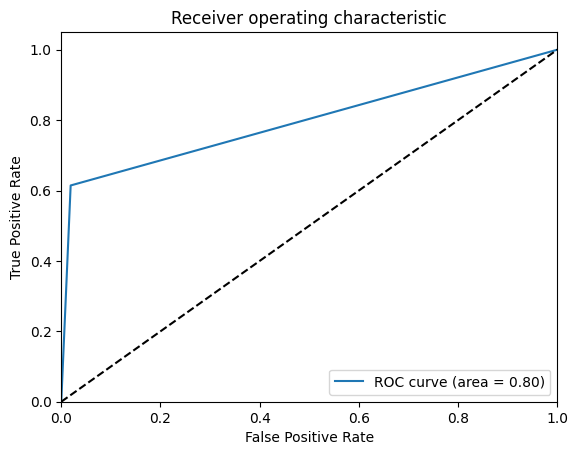

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

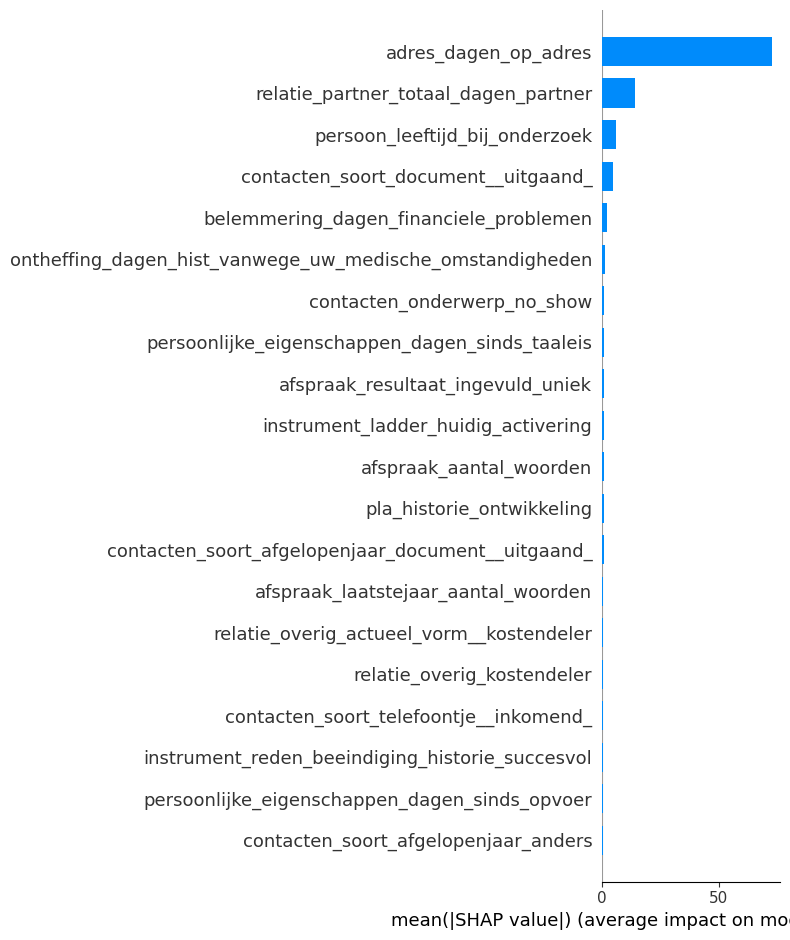

In [ ]:

# Create a TreeExplainer for the GradientBoostingClassifier model
explainer = shap.TreeExplainer(pipeline.named_steps['classification'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
m_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=y_test)
m_eqo = equalized_odds_ratio(y_test, y_pred, sensitive_features=y_test)
print(f'Value of demographic parity ratio: {round(m_dpr, 2)}')
print(f'Value of equal odds ratio: {round(m_eqo, 2)}')

Value of demographic parity ratio: 0.03
Value of equal odds ratio: 0.0


In [ ]:
threshold_optimizer = ThresholdOptimizer(
    estimator=pipeline,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=False,
)

In [ ]:
threshold_optimizer.fit(X_train, y_train, sensitive_features=X_train)


ValueError: Degenerate labels for sensitive feature value 1.0,1.0,0.0,0.0,10070.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,287.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,1.0,0.0,68.0,1.0,2.0,1.0,1.0,3.0,4.0,5.0,0.0,0.0,0.0,1.0,1.0,2168.0,8516.0,12342.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,5.0,5.0,0.0,4.0,1.0,2.0,3.0,2.0,1.0,0.0,1.0,1.0,5.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,2.0,6.0,3.0,0.0,0.0,2.0,2.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,14.0,45.0,5.0,4.0,0.0,1.0,2.0,3.0,9.0,5.0,2.0,2.0,5.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,624.0,455.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57.0,0.0,199.0,534.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,22.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,1984.0,1.0,3332.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0

In [ ]:
y_pred_opt = threshold_optimizer.predict(X_test, sensitive_features=A_test)

print(
    json.dumps(
        threshold_optimizer.interpolated_thresholder_.interpolation_dict,
        default=str,
        indent=4,
    )
)

plot_threshold_optimizer(threshold_optimizer) 